<a href="https://colab.research.google.com/github/SantiagoMengual/Politicas-Publicas/blob/main/IA_TP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from folium.plugins import MarkerCluster
from shapely.geometry import Polygon, MultiPolygon
from shapely import wkt



Estudiantes: Quinn, María Cecilia; Mengual, Santiago; Duré, Francisco

Planteo de objetivos

Preparación de la base sobre la cual trabajar

Extracción de variables a estudiar

Modelado de la descripción

Representación de la información

Presentación y comunicación de la información

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Maestria/I.A/Bases/mendoza/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carga y recorte de la base
Renabap=pd.read_excel(data_path + 'renabap_Base_MendozaySantafe.xlsx')

Renabap_Mendoza = Renabap[Renabap['Listado Nacional de Barrios 2018_Provincia'] == 'Mendoza']

In [ ]:
# Manejo de missing en 'Decada de Creacion' imputando 'Desconocido'

Renabap_Mendoza = Renabap_Mendoza.dropna(subset=['Decada de Creacion'])


In [ ]:
Renabap_Mendoza = Renabap_Mendoza.dropna(subset=['Decada de Creacion'])


In [ ]:
# Create the new category '1970 o antes'
decades_to_group = ['Decada 1970', 'Decada 1960', 'Decada 1950', 'Decada 1940', 'Decada 1930']
Renabap_Mendoza.loc[Renabap_Mendoza['Decada de Creacion'].isin(decades_to_group), 'Decada de Creacion'] = 'Decada 1970 o antes'

print("Decada de Creacion:")
print(Renabap_Mendoza['Decada de Creacion'].value_counts(dropna=False))

Decada de Creacion:
Decada de Creacion
Decada 2010            76
Decada 2000            56
Decada 1990            47
Decada 1980            37
Decada 1970 o antes    30
Name: count, dtype: int64


In [ ]:
# prompt: Quiero conocer como se componen las variables 'Electricidad',
#                     'Cloacas', 'Agua', 'Cocina', 'Calefaccion'

import pandas as pd

# Assuming your dataframe is named Renabap_Mendoza
# Replace with your actual dataframe name if it's different.

# Print unique values and counts for each variable
print("Electricidad:")
print(Renabap_Mendoza['Electricidad'].value_counts(dropna=False))

print("\nCloacas:")
print(Renabap_Mendoza['Cloacas'].value_counts(dropna=False))

print("\nAgua:")
print(Renabap_Mendoza['Agua'].value_counts(dropna=False))

print("\nCocina:")
print(Renabap_Mendoza['Cocina'].value_counts(dropna=False))

print("\nCalefaccion:")
print(Renabap_Mendoza['Calefaccion'].value_counts(dropna=False))

Electricidad:
Electricidad
Conexion irregular a la red piºblica                                                      183
Conexion formal a la red piºblica de energi­a electrica con medidores domiciliarios.       41
Conexion a la red piºblica con medidor comunitario / social                                15
Conexion regular a la red piºblica con medidores domiciliarios pero sin boleta/factura      6
No tiene conexion electrica                                                                 1
Name: count, dtype: int64

Cloacas:
Cloacas
Desague solo a pozo negro/ciego u hoyo          195
Desague a camara septica y pozo ciego            34
Conexion irregular a la red cloacal piºblica     14
Conexion formal a la red cloacal piºblica         2
Desague a intemperie o cuerpo de agua             1
Name: count, dtype: int64

Agua:
Agua
Conexion irregular a la red piºblica de agua corriente                        206
Conexion regular al agua corriente de red piºblica pero sin boleta/factura     

In [ ]:
# prompt: Quiero transformar las variable  'Electricidad'.  La categoria 'Conexion formal a la red piºblica de energi­a electrica con medidores domiciliarios.' se transforme en 'legal ' y el resto de las categorias se agrupen en una nueva categoria llamada ilegal

# Transform the 'Electricidad' variable
Renabap_Mendoza['Electricidad'] = Renabap_Mendoza['Electricidad'].replace(
    'Conexion formal a la red piºblica de energi­a electrica con medidores domiciliarios.', 'legal'
)

# Group other categories into 'ilegal'
Renabap_Mendoza.loc[
    ~Renabap_Mendoza['Electricidad'].isin(['legal']), 'Electricidad'
] = 'ilegal'

# Print unique values and counts for the transformed variable
print("\nTransformed Electricidad:")
print(Renabap_Mendoza['Electricidad'].value_counts(dropna=False))





Transformed Electricidad:
Electricidad
ilegal    205
legal      41
Name: count, dtype: int64


In [ ]:
# prompt: En la variable Cloacas, quiero agrupar las categorias Conexion formal al agua corriente de red piºblica y Conexion irregular a la red cloacal piºblica como legal  y al resto de las categorias como ilegal

# Group categories in 'Cloacas' variable
Renabap_Mendoza['Cloacas'] = np.where(
    Renabap_Mendoza['Cloacas'].isin(['Conexion formal a la red cloacal piºblica','Conexion irregular a la red cloacal piºblica']),
    'legal',
    'ilegal'
)



#


# Agua
Renabap_Mendoza['Agua'] = np.where(
    Renabap_Mendoza['Agua'].isin(['Conexion regular al agua corriente de red piºblica pero sin boleta/factura', 'Conexion formal al agua corriente de red piºblica   ']),
    'legal',
    'ilegal'
)




In [ ]:

print(Renabap_Mendoza['Cloacas'].value_counts(dropna=False))

Cloacas
ilegal    230
legal      16
Name: count, dtype: int64


In [ ]:
categorical_vars = ['Decada de Creacion','Electricidad', 'Cloacas', 'Agua']

In [ ]:
# Preprocesar variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_vars)
    ], remainder='drop'
)



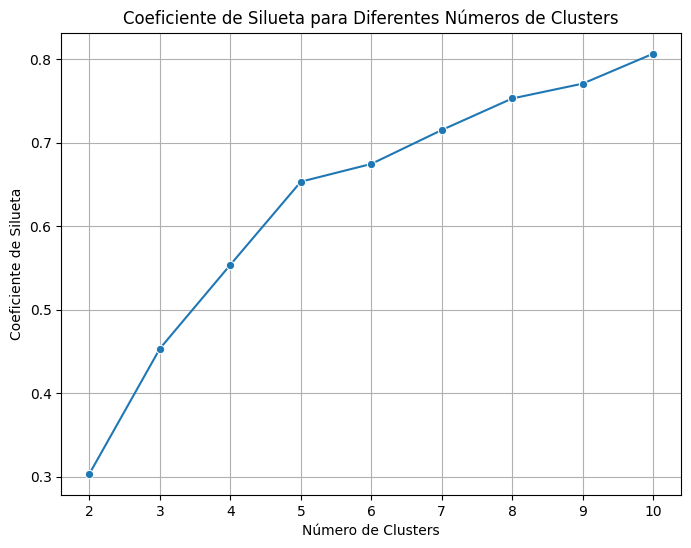

In [ ]:
# Fiteo de los datos
X = preprocessor.fit_transform(Renabap_Mendoza)

# Definción de rangos de clusters a testear
rango_clusters = range(2, 11)
coeficientes_silueta = []

# Iteración de k means para los distintos números de cluster y calculo de coeficiente de silueta
for k in rango_clusters:
    kmeans_result = KMeans(n_clusters=k, random_state=0)
    kmeans_result.fit(X)
    sil_score = silhouette_score(X, kmeans_result.labels_)
    coeficientes_silueta.append(sil_score)

# Dataframe para output de la iteración
data_frame = pd.DataFrame({
    'NumeroClusters': rango_clusters,
    'CoeficienteSilueta': coeficientes_silueta
})

# Gráfico de resultados
plt.figure(figsize=(8, 6))
sns.lineplot(data=data_frame, x='NumeroClusters', y='CoeficienteSilueta', marker='o')
plt.title("Coeficiente de Silueta para Diferentes Números de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silueta")
plt.grid(True)
plt.show()

In [ ]:
data_frame

,NumeroClusters,CoeficienteSilueta
0,2,0.303696
1,3,0.453634
2,4,0.553957
3,5,0.653431
4,6,0.674715
5,7,0.715320
6,8,0.753116
7,9,0.770878
8,10,0.806724


In [ ]:
# Set the number of clusters (e.g., 3, but this can be tuned)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Run the clustering
kmeans.fit(X)

# Assign cluster labels to the original DataFrame
Renabap_Mendoza.loc[:, 'Cluster'] = kmeans.labels_

# Métricas de evaluación

sil_score = silhouette_score(X, kmeans.labels_)
inertia = kmeans.inertia_

print(f"Silhouette Score: {sil_score}")
print(f"Inertia: {inertia}")

Silhouette Score: 0.612335164640572
Inertia: 125.89509376351451


In [ ]:
Renabap_Mendoza.loc[:, 'poli­gono'] = Renabap_Mendoza['poli­gono'].apply(wkt.loads)

In [ ]:
# Armar GDF
Renabap_Mendoza = gpd.GeoDataFrame(Renabap_Mendoza, geometry='poli­gono')

# Convertir CRS del GDF
Renabap_Mendoza = Renabap_Mendoza.set_crs('EPSG:4326', allow_override=True)

# Armar mapa con centroide de cada barrio
centroid = Renabap_Mendoza.geometry.unary_union.centroid
folium_map = folium.Map(location=[centroid.y, centroid.x], zoom_start=12)

# Marcador por cluster
marker_cluster = MarkerCluster().add_to(folium_map)

# Color por cluster
cluster_colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple'}

# Iteración para cada barrio por cluster y color
for idx, row in Renabap_Mendoza.iterrows():
    cluster = row['Cluster']
    polygon = row['poli­gono']
    if isinstance(polygon, MultiPolygon):
        for single_polygon in polygon.geoms:
            folium.GeoJson(single_polygon.__geo_interface__,
                           style_function=lambda feature, cluster=cluster: {
                               'fillColor': cluster_colors.get(cluster, 'gray'),
                               'color': 'black',
                               'weight': 1,
                               'fillOpacity': 0.5
                           }).add_to(folium_map)
    elif isinstance(polygon, Polygon):
        folium.GeoJson(polygon.__geo_interface__,
                       style_function=lambda feature, cluster=cluster: {
                           'fillColor': cluster_colors.get(cluster, 'gray'),
                           'color': 'black',
                           'weight': 1,
                           'fillOpacity': 0.5
                       }).add_to(folium_map)

    # Poner marcador en el centroide
    polygon_centroid = polygon.centroid
    folium.CircleMarker(
        location=[polygon_centroid.y, polygon_centroid.x],
        radius=7,
        color=cluster_colors.get(cluster, 'gray'),
        fill=True,
        fill_color=cluster_colors.get(cluster, 'gray'),
        fill_opacity=0.6,
        popup=f"Cluster {cluster}: {row['Nombre Barrio']}"
    ).add_to(marker_cluster)

# Mostrar mapa
folium_map

<ipython-input-115-a46eba846a87>:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = Renabap_Mendoza.geometry.unary_union.centroid


# **Modelo de predicción y regresión logística**



In [ ]:
# Para un mejor manejo de los datos, nos quedamos con las columnas que vamos a utilizar
Renabap = Renabap_Mendoza[['Decada de Creacion','Electricidad', 'Cloacas', 'Agua']].copy()

In [ ]:
# Importamos las librerias necesarias para poder entrenar nuestro modelo y

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score




In [ ]:

# Convertimos las variables en variables dummy

# En década de creación dejamos afuera a la década más antigua
# En base a los barrios creados antes de 1970 se comprararan el resto de las décadas

Renabap_transformed = pd.get_dummies(Renabap, columns=['Decada de Creacion'], drop_first=True)

# Ahora convertimos las variables 'Electricidad', 'Agua' y 'Cloacas' en binarios (0 y 1)
Renabap_transformed['Electricidad'] = Renabap_transformed['Electricidad'].apply(lambda x: 1 if x == 'legal' else 0)
Renabap_transformed['Agua'] = Renabap_transformed['Agua'].apply(lambda x: 1 if x == 'legal' else 0)
Renabap_transformed['Cloacas'] = Renabap_transformed['Cloacas'].apply(lambda x: 1 if x == 'legal' else 0)



# ***Electricidad***

In [ ]:

# 1. Predicción de Electricidad
x = Renabap_transformed.drop(columns=['Electricidad', 'Agua', 'Cloacas'])
y = Renabap_transformed['Electricidad']


#Normalizamos la variable predictora
x_norm = (x - x.mean()) / x.std()

#Como la muestra está muy desbalanceada (la mayoria de las conexiones son ilegales), estratificamos y
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.2, random_state=42, stratify=y)

x_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)

##Penalizamos la colinealidad y y mantenemos una regularización media
#Para obtener resultados regulares en el test

model1 = LogisticRegression(solver='liblinear', random_state=0, verbose=True,
                            C=0.5, penalty='l2')
model1.fit(x_train, y_train)

y_pred_electricidad = model1.predict(x_test)
accuracy_electricidad = accuracy_score(y_test, y_pred_electricidad)
print("Accuracy de Electricidad:", accuracy_electricidad)

coef1 = pd.DataFrame(model1.coef_).T

coef1['Decadas'] = x_train.columns
#La exactitud de nuestro modelo es de 84%

[LibLinear]Accuracy de Electricidad: 0.84


In [ ]:
print(coef1)


          0                         Decadas
0 -0.158371  Decada de Creacion_Decada 1980
1 -0.323649  Decada de Creacion_Decada 1990
2 -0.141328  Decada de Creacion_Decada 2000
3 -0.793435  Decada de Creacion_Decada 2010


In [ ]:
#Creamos nuestro objeto predictor y lo entrenamos.

y_pred1=pd.DataFrame(model1.predict_proba(x_train), index=x_train.index)
y_pred1['pct_rank'] = np.round(y_pred1[0].rank(pct=True) * 10, 0)

y_pred1['legal'] = y_train
y_pred1['ilegal'] = np.where(y_pred1['legal'] == 0, 1, 0)

y_pred1 = y_pred1[['pct_rank', 'legal', 'ilegal']]
y_pred1b = y_pred1.groupby(['pct_rank']).sum()

print(y_pred1b)

          legal  ilegal
pct_rank               
1.0           9      17
2.0          10      34
4.0           6      23
6.0           5      30
8.0           3      59


<ipython-input-327-9d95d2aca3dd>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Característica', data=coef1, palette='viridis')


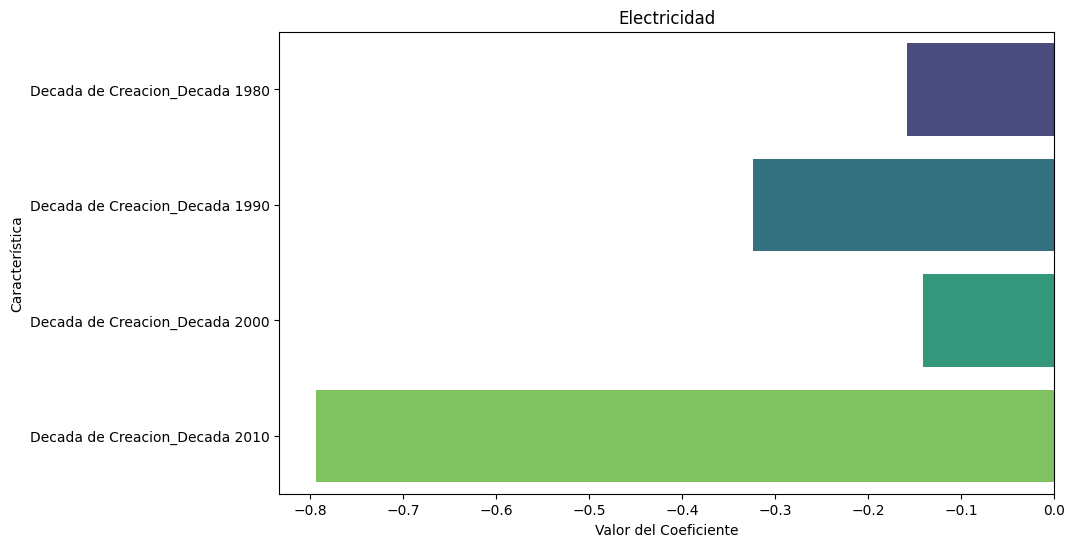

In [ ]:
## Realizamos un gráfico de barras de la regresión logística

import matplotlib.pyplot as plt
import seaborn as sns

# Asumimos que coef1 ya contiene los coeficientes del modelo
# Lo que debes hacer es transponerlo y asignar nombres a las columnas

coef1 = pd.DataFrame(model1.coef_, columns=x_train.columns).T  # Transponemos para que sea más fácil trabajar con los nombres de columnas
coef1.columns = ['Coeficiente']  # Renombramos la columna

# Añadimos una columna con el nombre de las características
coef1['Característica'] = coef1.index

# Graficamos
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Característica', data=coef1, palette='viridis')

# Agregamos etiquetas y título
plt.xlabel('Valor del Coeficiente')
plt.ylabel('Característica')
plt.title('Electricidad')

# Mostrar el gráfico
plt.show()


# **Agua**

In [ ]:
x = Renabap_transformed.drop(columns=['Electricidad', 'Agua', 'Cloacas'])
y = Renabap_transformed['Agua']

x_norm = (x - x.mean()) / x.std()


x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.2, random_state=42, stratify=y)

x_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)

##Hablar de la penalizacion por la colinealidad
model1 = LogisticRegression(solver='liblinear', random_state=0, verbose=True,
                            C=0.5, penalty='l2')
model1.fit(x_train, y_train)

coef1 = pd.DataFrame(model1.coef_).T

coef1['Decadas'] = x_train.columns


[LibLinear]

In [ ]:
print(coef1)

          0                         Decadas
0 -0.248579  Decada de Creacion_Decada 1980
1  0.186672  Decada de Creacion_Decada 1990
2  0.074718  Decada de Creacion_Decada 2000
3 -0.103762  Decada de Creacion_Decada 2010


In [ ]:
y_pred1=pd.DataFrame(model1.predict_proba(x_train), index=x_train.index)
y_pred1['pct_rank'] = np.round(y_pred1[0].rank(pct=True) * 10, 0)

y_pred1['legal'] = y_train
y_pred1['ilegal'] = np.where(y_pred1['legal'] == 0, 1, 0)

y_pred1 = y_pred1[['pct_rank', 'legal', 'ilegal']]
y_pred1b = y_pred1.groupby(['pct_rank']).sum()

print(y_pred1b)

<ipython-input-289-62178c5e5102>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Característica', data=coef1, palette='viridis')


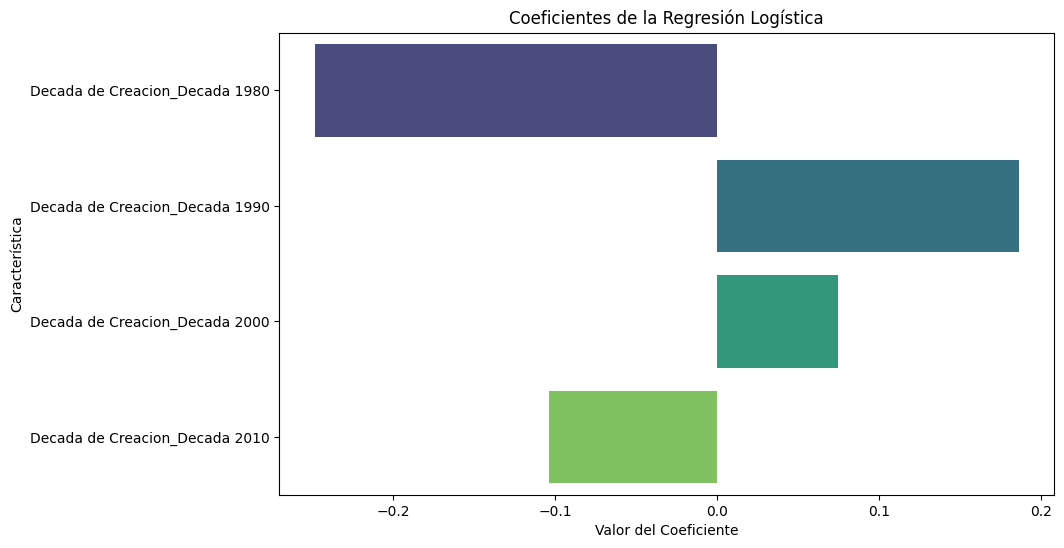

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumimos que coef1 ya contiene los coeficientes del modelo
# Lo que debes hacer es transponerlo y asignar nombres a las columnas

coef1 = pd.DataFrame(model1.coef_, columns=x_train.columns).T  # Transponemos para que sea más fácil trabajar con los nombres de columnas
coef1.columns = ['Coeficiente']  # Renombramos la columna

# Añadimos una columna con el nombre de las características
coef1['Característica'] = coef1.index

# Graficamos
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Característica', data=coef1, palette='viridis')

# Agregamos etiquetas y título
plt.xlabel('Valor del Coeficiente')
plt.ylabel('Característica')
plt.title('Coeficientes de la Regresión Logística')

# Mostrar el gráfico
plt.show()


# **Cloacas**

In [ ]:
x = Renabap_transformed.drop(columns=['Electricidad', 'Agua', 'Cloacas'])
y = Renabap_transformed['Cloacas']

x_norm = (x - x.mean()) / x.std()


x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.2, random_state=42, stratify=y)

x_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)


##Hablar de la penalizacion por la colinealidad
model1 = LogisticRegression(solver='liblinear', random_state=0, verbose=True,
                            C=0.5, penalty='l2')
model1.fit(x_train, y_train)

coef1 = pd.DataFrame(model1.coef_).T

coef1['Decadas'] = x_train.columns


[LibLinear]

In [ ]:
y_pred1=pd.DataFrame(model1.predict_proba(x_train), index=x_train.index)
y_pred1['pct_rank'] = np.round(y_pred1[0].rank(pct=True) * 10, 0)

y_pred1['legal'] = y_train
y_pred1['ilegal'] = np.where(y_pred1['legal'] == 0, 1, 0)

y_pred1 = y_pred1[['pct_rank', 'legal', 'ilegal']]
y_pred1b = y_pred1.groupby(['pct_rank']).sum()

print(y_pred1b)

          legal  ilegal
pct_rank               
1.0           5      22
2.0           3      33
4.0           2      24
6.0           2      60
9.0           1      44


<ipython-input-312-eca6ae9832df>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Característica', data=coef1, palette='viridis')


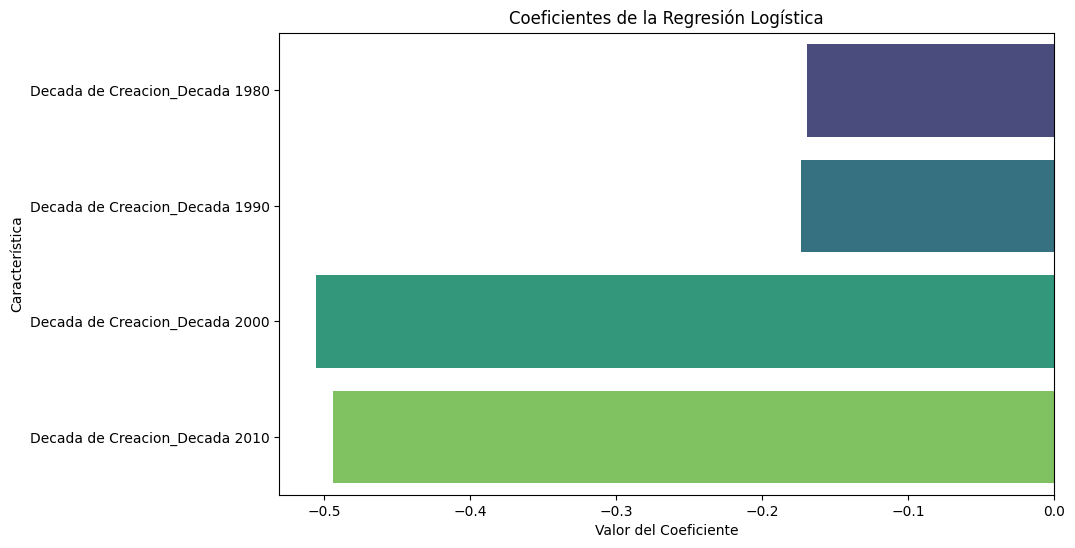

In [ ]:
coef1 = pd.DataFrame(model1.coef_, columns=x_train.columns).T  # Transponemos para que sea más fácil trabajar con los nombres de columnas
coef1.columns = ['Coeficiente']  # Renombramos la columna

# Añadimos una columna con el nombre de las características
coef1['Característica'] = coef1.index

# Graficamos
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Característica', data=coef1, palette='viridis')

# Agregamos etiquetas y título
plt.xlabel('Valor del Coeficiente')
plt.ylabel('Característica')
plt.title('Coeficientes de la Regresión Logística')

# Mostrar el gráfico
plt.show()